<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install transformers --quiet
!pip install wget --quiet

In [9]:
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [10]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 128
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=5):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print('Accuracy:', score_to_percent(accuracy_score(y_valid, predictions_valid)))
            print("Recall:", score_to_percent(recall_score(y_valid, predictions_valid)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            print('*'*21)
            print(classification_report(y_test, predictions_test))
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print("Precision:",score_to_percent(precision_score(y_test, predictions_test)))
            print("F1-score:", score_to_percent(f1_score(y_test, predictions_test)), '\n')
            print('*' * 21)
            
            plot_cm(y_test,predictions_test)
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [11]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
#   print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
#   print("Recall:", score_to_percent(recall_score(y_test, pred)))
#   print("Precision:",score_to_percent(precision_score(y_test, pred)))
#   print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [12]:
import wget
import os
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [13]:
import pandas as pd
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.15, random_state=42)
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1764705882352941, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12250,)
(10088,)
(2162,)
(2162,)


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

**********
Model: cointegrated/rubert-tiny
Epoch 1/7


100%|██████████| 5044/5044 [01:59<00:00, 42.36it/s]


Train loss 0.5701633196028548 accuracy 0.820975416336241
Valid:
Accuracy: 87.33 %
Recall: 77.75 %
precision: 0.864030046814505, recall: 0.8501416363160275, f1score: 0.8563448182206186
Test:
Accuracy: 88.34 %
Recall: 79.66 %
precision: 0.8706449730030626, recall: 0.860938677575884, f1score: 0.8654803384768541
*********************
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1459
           1       0.84      0.80      0.82       703

    accuracy                           0.88      2162
   macro avg       0.87      0.86      0.87      2162
weighted avg       0.88      0.88      0.88      2162

Accuracy: 88.34 %
Recall: 79.66 %
Precision: 83.71 %
F1-score: 81.63 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1350
False Positives:  109
False Negatives:  143
True Positives:  560
Epoch 2/7


100%|██████████| 5044/5044 [01:59<00:00, 42.37it/s]


Train loss 0.438545537657142 accuracy 0.8969072164948454
Valid:
Accuracy: 88.9 %
Recall: 83.45 %
precision: 0.876821673825274, recall: 0.8758285129377038, f1score: 0.876321096062812
Test:
Accuracy: 90.01 %
Recall: 85.49 %
precision: 0.8850343851034936, recall: 0.8883859148640361, f1score: 0.886671902012955
*********************
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1459
           1       0.84      0.85      0.85       703

    accuracy                           0.90      2162
   macro avg       0.89      0.89      0.89      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 90.01 %
Recall: 85.49 %
Precision: 84.06 %
F1-score: 84.77 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1345
False Positives:  114
False Negatives:  102
True Positives:  601
Epoch 3/7


100%|██████████| 5044/5044 [01:58<00:00, 42.48it/s]


Train loss 0.35197143982443646 accuracy 0.9212926249008723
Valid:
Accuracy: 89.32 %
Recall: 83.72 %
precision: 0.8819227320796359, recall: 0.8796415053917017, f1score: 0.880761668737846
Test:
Accuracy: 90.33 %
Recall: 85.92 %
precision: 0.8887841048021419, recall: 0.8918904294431873, f1score: 0.890304934017832
*********************
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1459
           1       0.85      0.86      0.85       703

    accuracy                           0.90      2162
   macro avg       0.89      0.89      0.89      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 90.33 %
Recall: 85.92 %
Precision: 84.59 %
F1-score: 85.25 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1349
False Positives:  110
False Negatives:  99
True Positives:  604
Epoch 4/7


100%|██████████| 5044/5044 [01:58<00:00, 42.50it/s]


Train loss 0.2895061897923299 accuracy 0.9385408406026963
Valid:
Accuracy: 89.22 %
Recall: 85.89 %
precision: 0.8782114735658042, recall: 0.8841805327429837, f1score: 0.881042582960912
Test:
Accuracy: 90.43 %
Recall: 87.06 %
precision: 0.8886002421567275, recall: 0.8955241269912457, f1score: 0.8918969449136606
*********************
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1459
           1       0.84      0.87      0.86       703

    accuracy                           0.90      2162
   macro avg       0.89      0.90      0.89      2162
weighted avg       0.91      0.90      0.90      2162

Accuracy: 90.43 %
Recall: 87.06 %
Precision: 84.07 %
F1-score: 85.53 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1343
False Positives:  116
False Negatives:  91
True Positives:  612
Epoch 5/7


100%|██████████| 5044/5044 [01:58<00:00, 42.45it/s]


Train loss 0.2387118308667713 accuracy 0.9510309278350515
Valid:
Accuracy: 89.5 %
Recall: 87.38 %
precision: 0.8802834821760257, recall: 0.8898888333452355, f1score: 0.8846766698741786
Test:
Accuracy: 89.55 %
Recall: 87.2 %
precision: 0.877365149286097, recall: 0.8893813549489752, f1score: 0.8828309046402234
*********************
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1459
           1       0.82      0.87      0.84       703

    accuracy                           0.90      2162
   macro avg       0.88      0.89      0.88      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 89.55 %
Recall: 87.2 %
Precision: 81.84 %
F1-score: 84.44 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1323
False Positives:  136
False Negatives:  90
True Positives:  613
Epoch 6/7


100%|██████████| 5044/5044 [01:59<00:00, 42.18it/s]


Train loss 0.19585993609235802 accuracy 0.9619349722442506
Valid:
Accuracy: 89.87 %
Recall: 84.4 %
precision: 0.8883328729175779, recall: 0.8854897760003808, f1score: 0.8868804625717004
Test:
Accuracy: 90.24 %
Recall: 84.64 %
precision: 0.8893325191413406, recall: 0.8878881948215667, f1score: 0.8886035901729936
*********************
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1459
           1       0.85      0.85      0.85       703

    accuracy                           0.90      2162
   macro avg       0.89      0.89      0.89      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 90.24 %
Recall: 84.64 %
Precision: 85.24 %
F1-score: 84.94 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1356
False Positives:  103
False Negatives:  108
True Positives:  595
Epoch 7/7


100%|██████████| 5044/5044 [01:59<00:00, 42.27it/s]


Train loss 0.17274520189210907 accuracy 0.9653053132434576
Valid:
Accuracy: 89.73 %
Recall: 85.07 %
precision: 0.8855711836378385, recall: 0.886074888714323, f1score: 0.8858220288663561
Test:
Accuracy: 89.92 %
Recall: 84.78 %
precision: 0.8847295333362497, recall: 0.8858578285366641, f1score: 0.8852894074582476
*********************
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1459
           1       0.84      0.85      0.85       703

    accuracy                           0.90      2162
   macro avg       0.88      0.89      0.89      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 89.92 %
Recall: 84.78 %
Precision: 84.3 %
F1-score: 84.54 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1348
False Positives:  111
False Negatives:  107
True Positives:  596
**********


('./trainer/tokenizer_config.json',
 './trainer/special_tokens_map.json',
 './trainer/vocab.txt',
 './trainer/added_tokens.json')

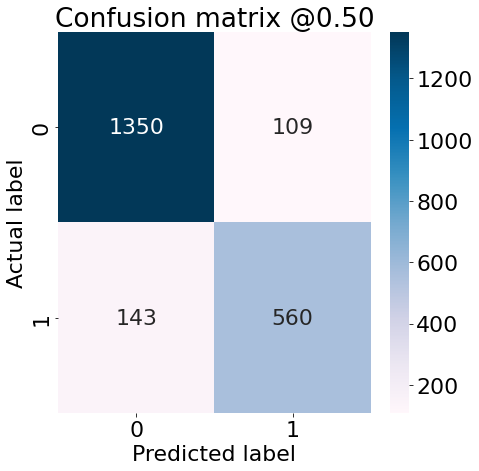

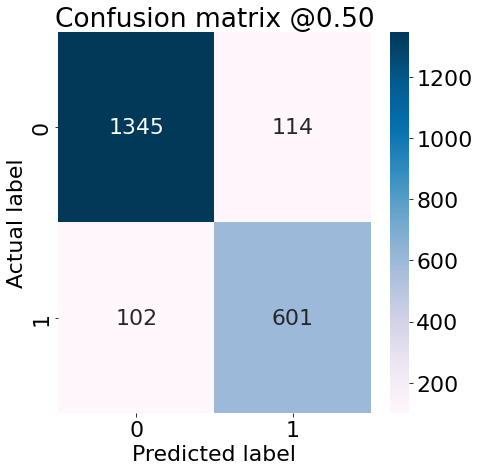

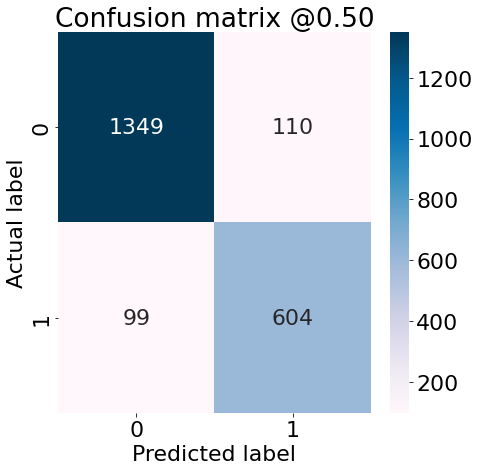

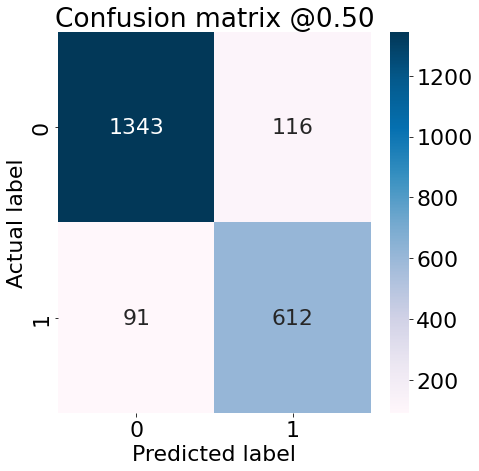

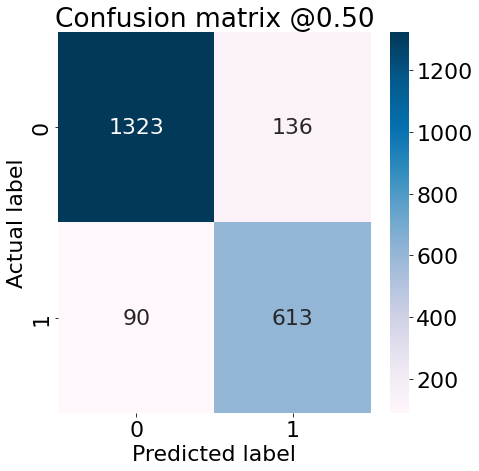

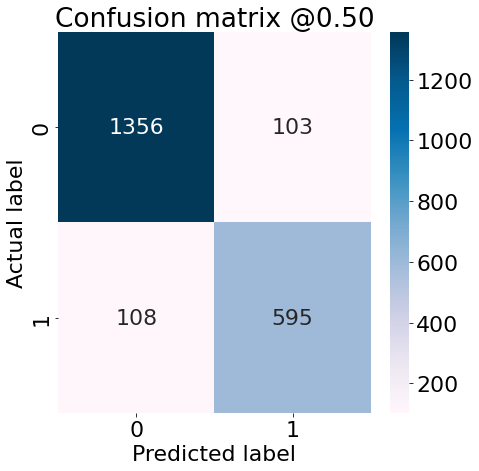

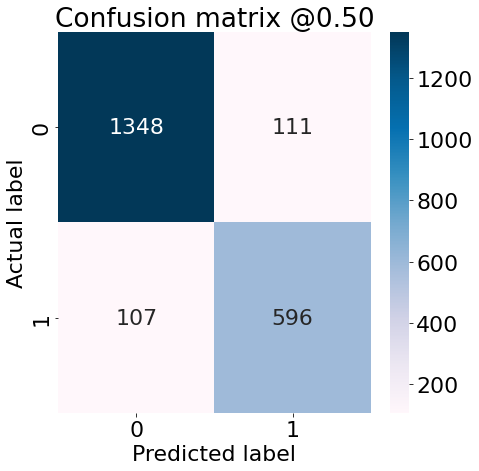

In [14]:
classifier = BertClassifier(
    path='cointegrated/rubert-tiny',
    n_classes=2
)

classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_val,
        y_valid=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=7
)

path = './trainer'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)